# **Task 2: Develop Time Series Forecasting Models**

In [2]:
!pip uninstall -y numpy pandas pmdarima
!pip install numpy==1.26.4 pandas==2.2.2 pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9

In [21]:
import os
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA and SARIMA
import pmdarima as pm

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Utilities for saving
import joblib

In [8]:
# 1. Load data
def load_data(ticker='TSLA', start='2015-07-01', end='2025-07-31'):
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        raise ValueError("No data fetched. Check ticker or date range.")
    return df['Close']

# 2. Split train-test chronologically
def train_test_split(series, train_end='2023-12-31'):
    train = series[:train_end]
    test = series[train_end:]
    if len(test) == 0:
        raise ValueError("Test set is empty. Adjust train_end date.")
    return train, test

# 3. ARIMA/SARIMA model training and forecasting
def arima_model(train, test, seasonal=False, m=5):
    print(f"Fitting {'SARIMA' if seasonal else 'ARIMA'} model with auto_arima...")
    model = pm.auto_arima(train, seasonal=seasonal, m=m, trace=False, error_action='ignore', suppress_warnings=True)
    print(f"Best order: {model.order} Seasonal order: {model.seasonal_order}")
    preds = model.predict(n_periods=len(test))
    return model, preds

# 4. LSTM data preparation
def create_lstm_dataset(series, look_back=20):
    X, y = [], []
    for i in range(look_back, len(series)):
        X.append(series[i-look_back:i])
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

# 5. LSTM model building, training and predicting
def lstm_model(train, test, look_back=20, epochs=20, batch_size=32):
    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
    test_scaled = scaler.transform(test.values.reshape(-1,1))

    # Fix: concatenate properly along axis=0 (rows)
    combined_scaled = np.concatenate((train_scaled[-look_back:], test_scaled), axis=0)

    X_train, y_train = create_lstm_dataset(train_scaled, look_back)
    X_test, y_test = create_lstm_dataset(combined_scaled, look_back)

    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM network
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(25),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])

    # Predict and invert scale
    preds_scaled = model.predict(X_test)
    preds = scaler.inverse_transform(preds_scaled).flatten()

    # Align y_test for evaluation
    y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    return model, preds, y_true

# 6. Evaluation metrics
def evaluate_performance(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# 7. Save models
def save_model(model, model_name):
    if model_name.lower() in ['arima', 'sarima']:
        joblib.dump(model, f'{model_name}_model.pkl')
    elif model_name.lower() == 'lstm':
        model.save(f'{model_name}_model.h5')
    print(f"Model saved: {model_name}")

In [9]:
 # Load data
series = load_data()

In [10]:
  # Split data
train, test = train_test_split(series)

In [11]:
# ARIMA (non-seasonal)
arima_mod, arima_preds = arima_model(train, test, seasonal=False)

# SARIMA (seasonal)
sarima_mod, sarima_preds = arima_model(train, test, seasonal=True, m=5)

Fitting ARIMA model with auto_arima...
Best order: (0, 1, 0) Seasonal order: (0, 0, 0, 0)
Fitting SARIMA model with auto_arima...
Best order: (3, 1, 4) Seasonal order: (2, 0, 2, 5)


In [12]:
# LSTM
lstm_mod, lstm_preds, lstm_true = lstm_model(train, test)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0441
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0024
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0025
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0019
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019
Epoch 15/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021
Epoc

In [16]:
def round_metrics(metrics):
    return tuple(np.round(metrics, 8))

       # Evaluate
arima_metrics = evaluate_performance(test.values, arima_preds)
sarima_metrics = evaluate_performance(test.values, sarima_preds)
lstm_metrics = evaluate_performance(lstm_true, lstm_preds)
# The decimal display:
arima_metrics = round_metrics(arima_metrics)
sarima_metrics = round_metrics(sarima_metrics)
lstm_metrics = round_metrics(lstm_metrics)

In [18]:
  # Display results
result = pd.DataFrame({
    "Model Performance Metrics": ["MAE", "RMSE", "MAPE"],
    "ARIMA": arima_metrics,
    "SARIMA": sarima_metrics,
    "LSTM": lstm_metrics
})
result.head()

,Model Performance Metrics,ARIMA,SARIMA,LSTM
0,MAE,62.969544,62.955520,13.765835
1,RMSE,77.963009,78.034859,18.927583
2,MAPE,24.089157,24.047317,5.193234


In [19]:
        # Save models
save_model(arima_mod, 'ARIMA')
save_model(sarima_mod, 'SARIMA')
save_model(lstm_mod, 'LSTM')

Model saved: ARIMA
Model saved: SARIMA
Model saved: LSTM


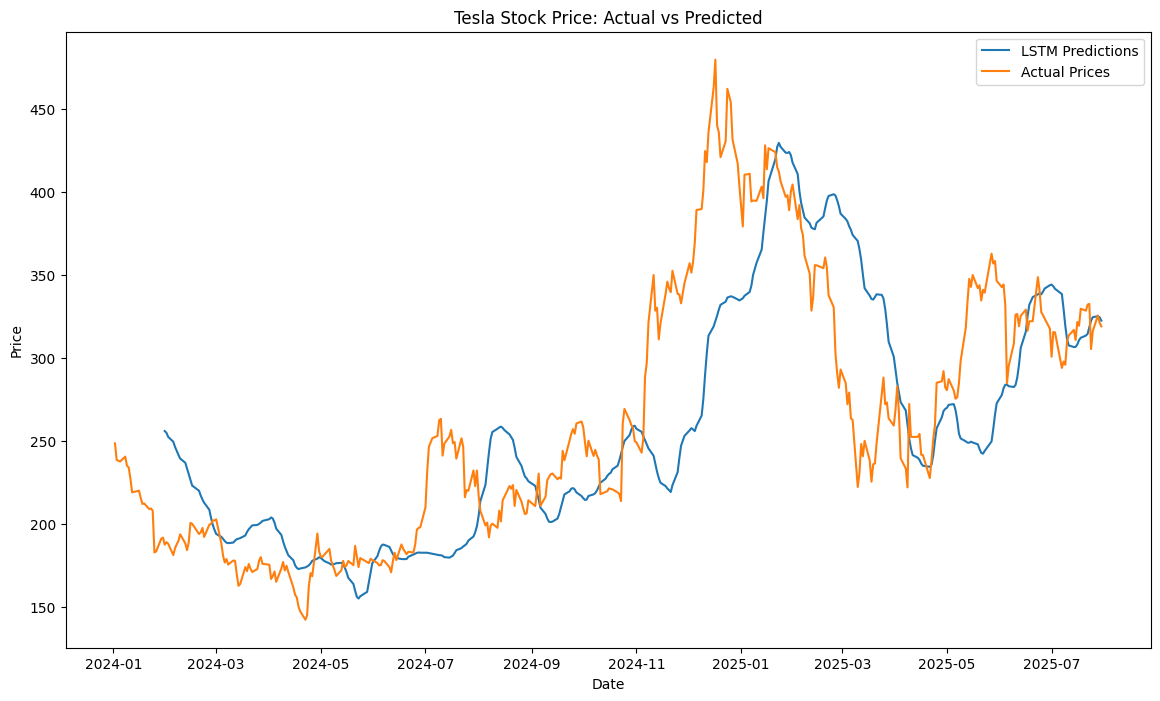

In [25]:
 # Visualization: plot actual vs predicted for all models
plt.figure(figsize=(14,8))
look_back = 20
lstm_pred_index = test.index[look_back:]

# Align predictions to the same length as index
lstm_preds = lstm_preds[:len(lstm_pred_index)]

plt.plot(lstm_pred_index, lstm_preds, label='LSTM Predictions')
plt.plot(test.index, test.values, label='Actual Prices')

plt.title("Tesla Stock Price: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

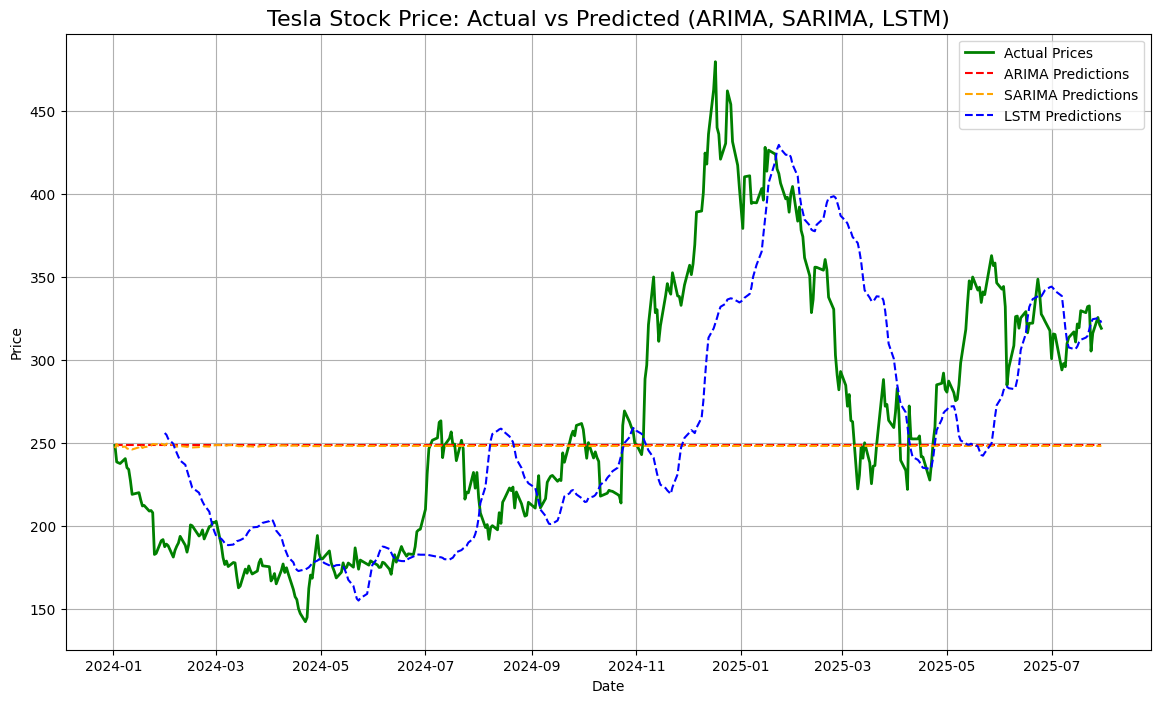

In [24]:
plt.figure(figsize=(14, 8))
look_back = 20
lstm_pred_index = test.index[look_back:]
lstm_preds = lstm_preds[:len(lstm_pred_index)]

# Align ARIMA & SARIMA predictions with test index
arima_preds = arima_preds[:len(test)]
sarima_preds = sarima_preds[:len(test)]

# Plot Actual Prices
plt.plot(test.index, test.values, label='Actual Prices', color='green', linewidth=2)

# Plot ARIMA
plt.plot(test.index, arima_preds, label='ARIMA Predictions', color ='red', linestyle='--')

# Plot SARIMA
plt.plot(test.index, sarima_preds, label='SARIMA Predictions', color ='orange', linestyle='--')

# Plot LSTM
plt.plot(lstm_pred_index, lstm_preds, label='LSTM Predictions', color ='blue', linestyle='--')

# Labels & title
plt.title("Tesla Stock Price: Actual vs Predicted (ARIMA, SARIMA, LSTM)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()